In [270]:
#Imports
import numpy as np
import pandas as pd
import os

In [303]:
#Load transated data with sentiment calculated
import utils, importlib
importlib.reload(utils)
data1g = pd.read_csv("data"+os.sep+"part"+os.sep+"Suomi112_cpd_google.csv", encoding='utf-8-sig')
data1g.drop(['Unnamed: 0','userName', 'reviewId', 'at','reviewCreatedVersion','score','thumbsUpCount'], axis=1, inplace=True)
data1g['type'] = utils.souce_type_dict["Suomi112_google"]
data1a = pd.read_csv("data"+os.sep+"part"+os.sep+"Suomi112_cpd_apple.csv", encoding='utf-8-sig')
data1a.drop(['Unnamed: 0','title', 'date', 'rating'], axis=1, inplace=True)
data1a['type'] = utils.souce_type_dict["Suomi112_apple"]
data2g = pd.read_csv("data"+os.sep+"part"+os.sep+"SosLive_cpd_google.csv", encoding='utf-8-sig')
data2g.drop(['Unnamed: 0','userName', 'reviewId', 'at','reviewCreatedVersion','score','thumbsUpCount'], axis=1, inplace=True)
data2g['type'] = utils.souce_type_dict["SosLive_google"]
data2a = pd.read_csv("data"+os.sep+"part"+os.sep+"SosLive_cpd_apple.csv", encoding='utf-8-sig')
data2a.drop(['Unnamed: 0','title', 'date', 'rating','developerResponse'], axis=1, inplace=True)
data2a['type'] = utils.souce_type_dict["SosLive_apple"]
#Merge all sources into one big dataframe (the type attrib will remember the source)
data = pd.concat([data1g,data1a,data2g,data2a],ignore_index = True)

In [304]:
#Print the data:
data

,content,sentiment,type
0,"The program is clear to use, only some informa...",Positive,0
1,The cerebral infarction patient was asked to v...,Negative,0
2,The 112 icon disappeared from the phone screen...,Positive,0
3,Positioning accuracy 1300m when I'm at home. 👎,Negative,0
4,A comfortable device,Negative,0
...,...,...,...
1890,Good App but it is not accessible for the deaf.,Positive,3
1891,Good app,Positive,3
1892,"However, the app lacks a lock or similar so th...",Positive,3
1893,Crazy that this didn't come up sooner. But bet...,Positive,3


In [305]:
#Recode the sentiment
import utils, importlib
importlib.reload(utils)
data['sentiment'] = [sentiment_dict[sent] for sent in data['sentiment']]
#data.loc[data['sentiment'] == utils.sentiment_dict["Neutral"], 'sentiment'] = utils.sentiment_dict["Negative"] # See Neutral as Negative
data = data.drop(data[data["sentiment"] == utils.sentiment_dict["Neutral"]].index) # Remove Neutral Reviews

In [306]:
#Preprocess the data
import utils, importlib
importlib.reload(utils) # to keep the .py file up to date when coding
processor = utils.Processor() # Init preprocessing <- there is a path to set up where to dowloads this v
processor.ini_dowload() #dowload all the nessesary files to do the preprocesing (like the dictionary of the stopwords)
data['content'] = data['content'].apply(lambda x: processor.preprocess(str(x))) #Used to get rid of the unnesesary characters and to stringify the emogis
data['content'] = data['content'].apply(lambda x: processor.tokenize(x)) # This is needed in the mext steps
#data['content'] = data['content'].apply(lambda x: processor.remove_stopwords(x)) # Remove stopwords (like in the topic task)
data['content'] = data['content'].apply(lambda x: processor.process_tokens(x))  # Strip the words into the root words
data['content'] = data['content'].apply(lambda x: processor.detokenize(x)) # Go back form tokens to text. Because sklearn Vektorizer neads text

[nltk_data] Downloading package stopwords to data/lib/stopwords...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to data/lib/wordnet...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to data/lib/omw...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [307]:
#Check the distribution of the data
import utils, importlib
importlib.reload(utils)
utils.count_data_stat(data)

Positive : 962
Negative : 514
Suomi112 google : 954
Suomi112 apple : 132
SosLive google : 105
SosLive apple : 285


In [308]:
#make data more balanced - optional (or use weigths in the classifier)
#rem_idxs = data[data.sentiment==sentiment_dict["Positive"]].sample(frac = 0.5,random_state=0).index
#data = data.drop(rem_idxs)

In [309]:
#split the data to train i test sets
test = data.sample(frac = 0.2,random_state=0)
train = data.drop(test.index)
#print("Siema Janek")

In [310]:
#Print the test/train proportions:
print("Train: ",len(train.content))
utils.count_data_stat(train)
print("Test: ", len(test.content))
utils.count_data_stat(test)

Train:  1181
Positive : 768
Negative : 413
Suomi112 google : 765
Suomi112 apple : 103
SosLive google : 83
SosLive apple : 230
Test:  295
Positive : 194
Negative : 101
Suomi112 google : 189
Suomi112 apple : 29
SosLive google : 22
SosLive apple : 55


In [311]:
#Vectorize the text into features model can understand:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
vectorizer = TfidfVectorizer(ngram_range = (2,3))
vectorizer.fit(list(train['content']))
train_X = vectorizer.transform(list(train['content']))
test_X = vectorizer.transform(list(test['content']))

In [312]:
#Choose and create classifier aka model aka clf:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
#Feel free to change the params of the model to make them better:
clf = RandomForestClassifier(n_estimators=1000, max_depth=200,min_samples_leaf=1,max_features="sqrt", criterion="gini", random_state=0, class_weight={0:1,1:0.5})
#clf = svm.SVC(kernel = "poly",degree=3, gamma="scale", C=1000,class_weight={0:1,1:0.5})
#And train it:
clf.fit(train_X, train['sentiment'])

RandomForestClassifier(class_weight={0: 1, 1: 0.5}, max_depth=200,
                       n_estimators=1000, random_state=0)

In [313]:
#Perform the predicitons
#And print out the accuracies - mind the class unbalance!
from sklearn.metrics import accuracy_score
train_Y = clf.predict(train_X)
train_acc = accuracy_score(train['sentiment'],train_Y)
print("Training Acc = ",train_acc)

test_Y = clf.predict(test_X)
test_acc = accuracy_score(test['sentiment'],test_Y)
print("Test Acc = ",test_acc)

Training Acc =  0.9635901778154107
Test Acc =  0.711864406779661


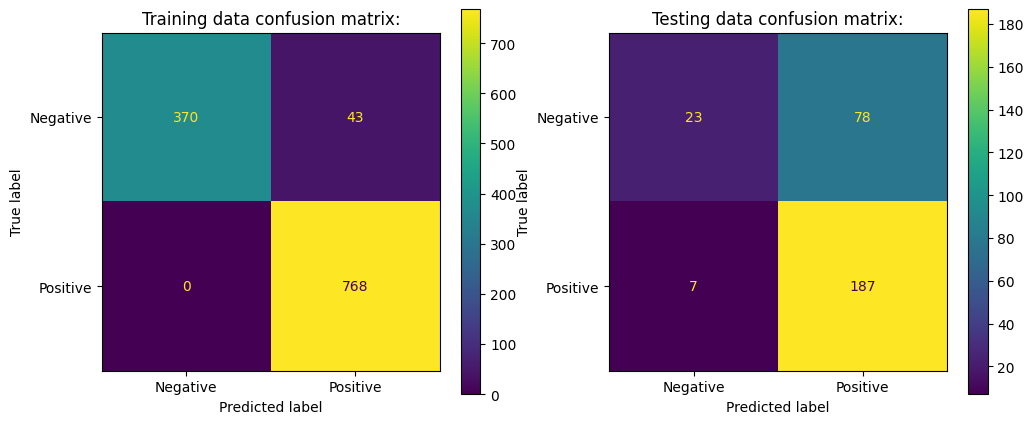

In [314]:
# Compute the confusion matrix function for training data and testing data respectively - best visualize of the model performance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = ['happy', 'sad']
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Calculate the confusion matrix when classifying the training data
ax[0].title.set_text('Training data confusion matrix:')
cm = confusion_matrix(train['sentiment'],train_Y)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive'])
cmd.plot(ax=ax[0])

# Calculate the confusion matrix when classifying the testing data
ax[1].title.set_text('Testing data confusion matrix:')
cm2 = confusion_matrix(test['sentiment'],test_Y)
cmd2 = ConfusionMatrixDisplay(cm2, display_labels=['Negative', 'Positive'])
cmd2.plot(ax=ax[1])

In [315]:
########Feature extraction:
#Create Feature selection tool:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(clf,prefit=True, max_features = 200)

In [316]:
#Select N best features and print them:
from itertools import compress
features = pd.DataFrame()
features["idx"] = sel.get_support(indices=True)
features["importance"] = sel.estimator.feature_importances_[features["idx"]]
features["names"] =  np.array(vectorizer.get_feature_names_out())[features["idx"]]
features["prediction"] = clf.predict(vectorizer.transform(features["names"]))

In [317]:
features

,idx,importance,names,prediction
0,13,0.001111,abl choos,1
1,215,0.000877,accid situat,1
2,224,0.000961,accident call,1
3,276,0.000548,accuraci home,1
4,1002,0.000682,announc corona,1
...,...,...,...,...
195,22511,0.000569,would like,1
196,22532,0.000638,would nice,1
197,22548,0.000748,would possibl,1
198,22622,0.000663,write number,1
